In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.style.use('seaborn')
torch.manual_seed(2019)

In [2]:
device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [40]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      #augmentation
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      #aug end
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))
                               ])

transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])

In [41]:
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False)


0it [00:00, ?it/s]


 26%|██▌       | 43835392/170498071 [00:13<00:32, 3894971.26it/s]


 63%|██████▎   | 106881024/170498071 [00:26<00:12, 5247550.33it/s]


 98%|█████████▊| 167550976/170498071 [00:39<00:00, 4233532.13it/s]


100%|█████████▉| 170295296/170498071 [00:40<00:00, 4446086.57it/s]

Files already downloaded and verified


In [42]:
training_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
                             RandomHorizontalFlip(p=0.5)
                             RandomRotation(degrees=(-10, 10), resample=False, expand=False)
                             RandomAffine(degrees=(0, 0), scale=(0.8, 1.2), shear=(-10, 10))
                             ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=None)
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None

In [43]:
#convert from tensor to numpy
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy() # (1,32,32)
    image = image.transpose(1, 2, 0) # (32,32,1)
    image = image * np.array((.5, .5, .5)) + np.array((.5, .5, .5)) #denormalize
    image = image.clip(0, 1)
    return image

In [44]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [45]:
dataiter = iter(training_loader)
images, labels = dataiter.next()

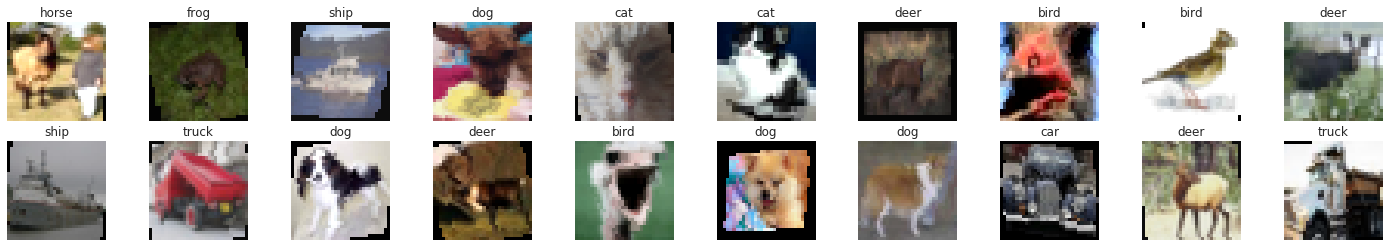


170500096it [00:55, 4446086.57it/s]                               

In [46]:
#Plot some images
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [47]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)#lkernel size = n of the filters
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(4*4*64, 500)#depth of 50 and 4x4 image
        self.dropout1 = nn.Dropout(0.5)#drop to prevent overfitting better used on large layers
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)#cut the zise of the picture in half but mantain the information
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)#cut the zise
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)#cut the zise
        x = x.view(-1, 4*4*64) #flatten to the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [48]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [49]:
criterion = nn.CrossEntropyLoss() # used for multiclass classification
optmizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [50]:
epochs = 10
running_loss_history = []
running_correct_history = []
val_running_loss_history = []
val_running_correct_history = []

for epoch in range(epochs):
    #each training batch
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs) # return proba for each class (score)
        loss = criterion(outputs, labels)
        
        optmizer.zero_grad()
        loss.backward()
        optmizer.step()
        
        #max score output class
        _, preds = torch.max(outputs, 1)
        
        running_loss += loss.item()
        #number of correct predictions
        running_corrects += torch.sum(preds == labels.data)
        
        
    else:
        #execute once loop end
        
        with torch.no_grad(): #set all the grad flags to false to get better perfomance
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                
                val_outputs = model(val_inputs) # return proba for each class (score)
                val_loss = criterion(val_outputs, val_labels)
                
                #max score output class
                _, val_preds = torch.max(val_outputs, 1)

                val_running_loss += val_loss.item()
                #number of correct predictions
                val_running_corrects += torch.sum(val_preds == val_labels.data)


            epoch_loss = running_loss/len(training_loader)#n of batches
            epoch_acc = running_corrects.float()/len(training_loader)
            running_loss_history.append(epoch_loss)
            running_correct_history.append(epoch_acc)
            
            val_epoch_loss = val_running_loss/len(validation_loader)#n of batches
            val_epoch_acc = val_running_corrects.float()/len(validation_loader)
            val_running_loss_history.append(val_epoch_loss)
            val_running_correct_history.append(val_epoch_acc)
            
            print('training loss: {:.4f} - training acc: {:.4f} | validation loss: {:.4f} - val acc: {:.4f}'.format(
                epoch_loss, epoch_acc.item(), val_epoch_loss, val_epoch_acc.item()))

training loss: 1.7014 - training acc: 37.4800 | validation loss: 1.3957 - val acc: 48.5700
training loss: 1.3948 - training acc: 49.2380 | validation loss: 1.2647 - val acc: 54.8000
training loss: 1.2703 - training acc: 54.2640 | validation loss: 1.1331 - val acc: 59.2100
training loss: 1.1896 - training acc: 57.6580 | validation loss: 1.0588 - val acc: 62.5900
training loss: 1.1224 - training acc: 60.3680 | validation loss: 1.0197 - val acc: 63.8800
training loss: 1.0770 - training acc: 62.0200 | validation loss: 0.9778 - val acc: 65.8000
training loss: 1.0347 - training acc: 63.5660 | validation loss: 0.9392 - val acc: 67.1500
training loss: 1.0028 - training acc: 64.5540 | validation loss: 0.9276 - val acc: 67.3800
training loss: 0.9718 - training acc: 65.9720 | validation loss: 0.9014 - val acc: 68.6600
training loss: 0.9483 - training acc: 66.8020 | validation loss: 0.8693 - val acc: 70.2000


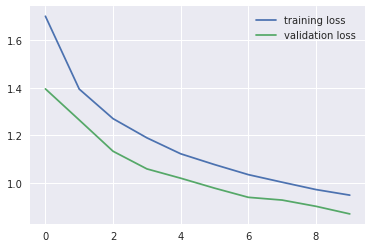

In [51]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

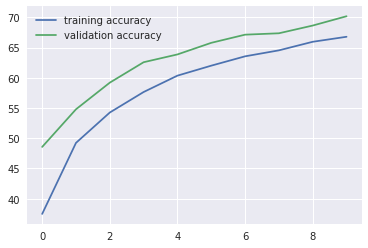

In [52]:
plt.plot(running_correct_history, label='training accuracy')
plt.plot(val_running_correct_history, label='validation accuracy')
plt.legend()

# test random images

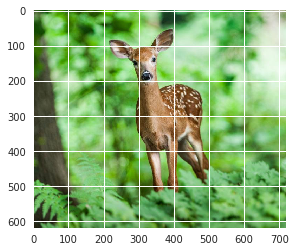

In [53]:
import PIL.ImageOps
import requests
from PIL import Image

url = 'https://www.almanac.com/sites/default/files/styles/primary_image_in_article/public/image_nodes/deer-1367217_1920-pixabay.jpg?itok=zRc4U14Y'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

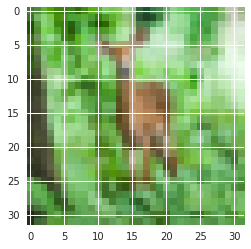

In [54]:
#Preprocessing
img = transform(img) 
plt.imshow(im_convert(img))

In [55]:
#predict
imgs = img.to(device).unsqueeze(0)
output = model(imgs)
_, pred = torch.max(output, 1)
print("Prediction: ", classes[pred.item()])

Prediction:  deer


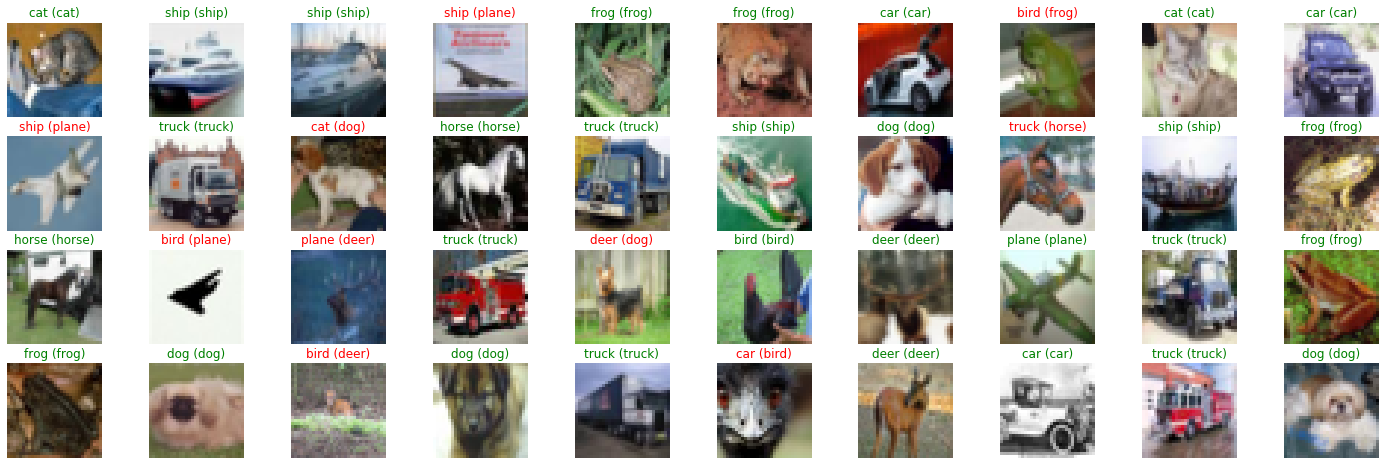

In [57]:
#predict all vals and print 20
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 8))

for idx in np.arange(40):
    ax = fig.add_subplot(4, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), 
                                  str(classes[labels[idx].item()])), 
                 color=("green" if preds[idx]==labels[idx] else "red"))

## example of too large learning rate, the gradient descent overshoot the minima: lr = 0.01

In [ ]:
plt.plot(running_loss_history, label='training loss')